In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

# by observation, the ParticleIDs are assigned in this way
def getPid(xid,yid,zid):
    return Ndim*Ndim*xid+Ndim*yid+zid

In [2]:
fileidx=63
f=h5py.File('snapshot_%03d.hdf5'%fileidx,'r')
Loc=np.array(list(f['PartType1']['Coordinates']))
ParticleIDs=np.array(list(f['PartType1']['ParticleIDs']))
currentz=dict(f['Header'].attrs)['Redshift']
Ndim=int(np.cbrt(dict(f['Header'].attrs)['NumPart_Total'][1]))
celllen=dict(f['Header'].attrs)['BoxSize']/Ndim # length of cell

In [3]:
#type in each particles' initial position on the grid
initLoc_manual = np.zeros_like(Loc)
for xid in range(Ndim):
    for yid in range(Ndim):
        for zid in range(Ndim):
            currentPid = getPid(xid,yid,zid)
            initLoc_manual[currentPid] = [ celllen/2 + xid * celllen, celllen/2 + yid * celllen, celllen/2 + zid * celllen ]


In [4]:
# connectivity of all tetrahedra
connectivity=[]
skip = 1
for xid in range(Ndim-skip):
    for yid in range(Ndim-skip):
        for zid in range(Ndim-skip):
            #find particle id of the vertices of this cube
            #print(getPid(xid,yid,zid))
            cubePids=[
                getPid(xid,yid,zid),
                getPid(xid+skip,yid,zid),
                getPid(xid+skip,yid+skip,zid),
                getPid(xid,yid+skip,zid),
                getPid(xid,yid,zid+skip),
                getPid(xid+skip,yid,zid+skip),
                getPid(xid+skip,yid+skip,zid+skip),
                getPid(xid,yid+skip,zid+skip)
            ]
            # connectivity list in each cell, refer to MNRAS 427, 61–76, first paragraph of Sec. 2.3
            connectivity.append( [ cubePids[4], cubePids[0], cubePids[3], cubePids[1] ] )
            connectivity.append( [ cubePids[7], cubePids[4], cubePids[3], cubePids[1] ] )
            connectivity.append( [ cubePids[7], cubePids[5], cubePids[4], cubePids[1] ] )
            connectivity.append( [ cubePids[7], cubePids[2], cubePids[5], cubePids[1] ] )
            connectivity.append( [ cubePids[7], cubePids[3], cubePids[2], cubePids[1] ] )
            connectivity.append( [ cubePids[7], cubePids[6], cubePids[5], cubePids[2] ] )
connectivity=np.array(connectivity)

In [5]:
#a simple way to sort the particles according to ID
Loc_sorted=np.copy(Loc)
Loc_sorted[ParticleIDs]=Loc

#take care of the periodic boundary
delta=Loc_sorted-initLoc_manual
Loc_shifted=np.copy(Loc_sorted)
for dim in range(3):
    too_small = delta[:,dim] < -20.0
    too_big = delta[:,dim] > 20.0
    Loc_shifted[too_big,dim] -= 40.0
    Loc_shifted[too_small,dim] += 40.0

#displacement field Phi
Phi = Loc_shifted - initLoc_manual

In [6]:
# compute the gradient of displacement fields in each tetrahedron
dPhidq=[]
for currentTetra in connectivity:

    P = np.zeros((4,3))
    P[0]=initLoc_manual[currentTetra[0]]
    P[1]=initLoc_manual[currentTetra[1]]
    P[2]=initLoc_manual[currentTetra[2]]
    P[3]=initLoc_manual[currentTetra[3]]

    myPhi = np.zeros((4,3))
    myPhi[0]=Phi[currentTetra[0]]
    myPhi[1]=Phi[currentTetra[1]]
    myPhi[2]=Phi[currentTetra[2]]
    myPhi[3]=Phi[currentTetra[3]]
    # take the center as the reference point where we compute the gradient
    center=(P[0]+P[1]+P[2]+P[3])/4
    centerPhi=(myPhi[0]+myPhi[1]+myPhi[2]+myPhi[3])/4
    # dq from center to P[1],P[2],P[3]
    dq = np.zeros((3,3))
    for i in [1,2,3]:
        for k in [1,2,3]:
            dq[i-1,k-1] = P[k][i-1] - center[i-1]
    # dPhi from center to P[1],P[2],P[3]
    deltaPhi = np.zeros((3,3))
    for j in [1,2,3]:
        for k in [1,2,3]:
            deltaPhi [j-1,k-1] = myPhi[k][j-1] - centerPhi [j-1]
    # solve the gradient
    mydPhidq = np.dot (deltaPhi,np.linalg.inv(dq)  )
    dPhidq.append(mydPhidq)

In [7]:
#get eigenvalues
eigenvalues, eigenvectors = np.linalg.eig(dPhidq)
Re_eigenvalues = np.real(eigenvalues)
Re_eigenvalues.sort(axis=1) # sort so that lamdba1<lambda2<lambda2

In [8]:
#get distribution
bin_range=5*np.std(Re_eigenvalues)
bin_disp=bin_range/50
tmp1=np.histogram(Re_eigenvalues[:,0],bins = np.arange(-bin_range,bin_range,bin_disp))
tmp2=np.histogram(Re_eigenvalues[:,1],bins = np.arange(-bin_range,bin_range,bin_disp))
tmp3=np.histogram(Re_eigenvalues[:,2],bins = np.arange(-bin_range,bin_range,bin_disp))

lambda_range=(tmp1[1][0:-1]+tmp1[1][1:len(tmp1[1])])/2
lambda1dist=tmp1[0]/np.trapz(tmp1[0],lambda_range) # normalized
lambda2dist=tmp2[0]/np.trapz(tmp2[0],lambda_range)
lambda3dist=tmp3[0]/np.trapz(tmp3[0],lambda_range) 

Text(0.5, 1.0, 'z= 0.000000')

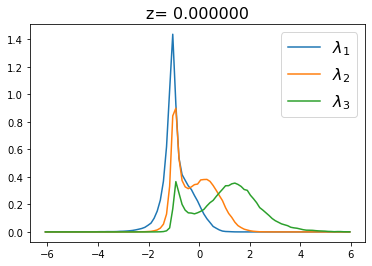

In [9]:
plt.plot(lambda_range,lambda1dist,label='$\\lambda_1$')
plt.plot(lambda_range,lambda2dist,label='$\\lambda_2$')
plt.plot(lambda_range,lambda3dist,label='$\\lambda_3$')
plt.legend(fontsize=16)
plt.title("z= %f"%currentz,fontsize=16)